# Main Jupyter notebook for Urdf2Moon

Jupyter used for debugging. We try to add a term to the cost function which is dependent by the final state and the final control value

In [1]:
from __future__ import print_function, division, absolute_import, unicode_literals
import casadi as cs
from urdf2casadi import urdfparser as u2c
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

In [2]:
class Urdf2Moon:
    def __init__(self, urdf_path, root, tip):
        self.robot_parser = self.load_urdf(urdf_path)

        # Store inputs
        self.root = root
        self.tip = tip
        
        # Get basic info
        self.num_joints = self.get_joints_n()
        self.define_symbolic_vars()
        self.M, self.Cq, self.G = self.get_motion_equation_matrix()
        self.M_inv = cs.pinv(self.M)
        self.upper_q, self.lower_q, self.max_effort, self.max_velocity = self.get_limits()

    def solve(self, cost_func, time_horizon, control_steps, initial_cond, trajectory_target, final_term_cost=None, rk_interval=4, max_iter=250):
        #Store Values
        self.t = cs.SX.sym("t", 1)
        self.traj ,self.traj_dot = self.derive_trajectory(trajectory_target, self.t)
        self.cost_func = cost_func
        self.final_term_cost = final_term_cost
        self.T = time_horizon
        self.N = control_steps
        self.rk_intervals = rk_interval
        self.max_iter = max_iter
        if len(initial_cond) == 2*self.num_joints:
            self.initial_cond = initial_cond
        else:
            raise ValueError('List should be {} item long: (q, q_dot)'.format(2*self.num_joints))
        

        # Fix boundaries if not given
        self.upper_u, self.lower_u = self.format_properly(self.max_effort)
        self.upper_qd, self.lower_qd = self.format_properly(self.max_velocity)

        # Working it up
        self.f = self.get_diff_eq(self.cost_func, self.traj)
        self.F = self.rk4(self.f, self.T, self.N, self.rk_intervals)
        self.nlp_solver(self.initial_cond, self.final_term_cost)
        return {'q': self.q_opt, 'qd': self.qd_opt, 
                'u': self.u_opt}


    def load_urdf(self, urdf_path):
        robot_parser = u2c.URDFparser()
        robot_parser.from_file(urdf_path)
        return robot_parser
    def get_joints_n(self):
        return self.robot_parser.get_n_joints(self.root, self.tip) #return the number of actuated joints
    def define_symbolic_vars(self):
        self.q = cs.SX.sym("q", self.num_joints)
        self.q_dot = cs.SX.sym("q_dot", self.num_joints)
        self.u = cs.SX.sym("u", self.num_joints) 
    def get_motion_equation_matrix(self):
        # load inertia terms (function)
        self.M_sym = self.robot_parser.get_inertia_matrix_crba(self.root, self.tip)
        # load gravity terms (function)
        gravity_u2c = [0, 0, -9.81]
        self.G_sym = self.robot_parser.get_gravity_rnea(self.root, self.tip, gravity_u2c)
        # load Coriolis terms (function)
        self.C_sym = self.robot_parser.get_coriolis_rnea(self.root, self.tip)
        # load frictional matrixes
        self.Ff, self.Fd = self.robot_parser.get_friction_matrixes(self.root, self.tip)
        return self.M_sym(self.q), self.C_sym(self.q, self.q_dot), self.G_sym(self.q)
    def get_limits(self):
        _, _, upper_q, lower_q = self.robot_parser.get_joint_info(self.root, self.tip)
        max_effort, max_velocity = self.robot_parser.get_other_limits(self.root, self.tip)
        return upper_q, lower_q, max_effort, max_velocity

    def format_properly(self, item):
        if item == None:
            upper = [float('inf')] * self.num_joints
            lower = [-float('inf')] * self.num_joints
        elif isinstance(item, list):
            if len(item) == self.num_joints:
                upper = item
                lower = [-x for x in item]
            else:
                raise ValueError('List lenght does not match the number of joints! It should be long {}'.format(self.num_joints))
        elif isinstance(item, (int, float)):
            upper = [item] * self.num_joints
            lower = [-item] * self.num_joints
        else:
            raise ValueError('Input should be a number or a list of numbers')
        return upper, lower

    def get_diff_eq(self, cost_func, traj):
        rhs1 = self.q_dot
        rhs2 = -cs.mtimes(self.M_inv, self.Cq) + cs.mtimes(self.M_inv, (self.u -self.G - cs.mtimes(self.Fd, self.q_dot)- cs.mtimes(self.Ff, cs.sign(self.q_dot))))
        
        J_dot = cost_func(self.q-self.traj, self.q_dot-self.traj_dot, self.u)
        
        self.x = cs.vertcat(self.q, self.q_dot)
        self.x_dot = cs.vertcat(rhs1, rhs2)
        f = cs.Function('f', [self.x, self.u, self.t],    # inputs
                             [self.x_dot, J_dot])  # outputs
        return f
    def rk4(self, f, T, N, m):
        dt = T/N/m

        # variable definition for RK method
        X0 = cs.MX.sym('X0', self.num_joints * 2)
        U = cs.MX.sym('U', self.num_joints)
        t = cs.MX.sym('t', 1)

        # Initial value
        X = X0
        Q = 0

        # Integration
        for j in range(m):
            k1, k1_q = f(X,  U,  t)
            k2, k2_q = f(X + dt/2 * k1, U,  t)
            k3, k3_q = f(X + dt/2 * k2, U,  t)
            k4, k4_q = f(X + dt * k3, U,  t)
            # update the state
            X = X + dt/6*(k1 +2*k2 +2*k3 +k4)    
            # update the cost function 
            Q = Q + dt/6*(k1_q + 2*k2_q + 2*k3_q + k4_q)

        F = cs.Function('F', [X0, U, t], [X, Q],['x0','p', 'time'],['xf','qf'])
        return F
    def nlp_solver(self, initial_cond, final_term_cost):
        # Start with an empty NLP
        w       = []    #input vector
        w_g     = []    #initial guess
        lbw     = []    #lower bounds of inputs
        ubw     = []    #upper bounds of inputs 
        J       = 0     #initial value of cost func
        g       = []    #joint state for all timesteps
        lbg     = []    #lower bounds of states
        ubg     = []    #upper bound of states
        
        self.t = cs.MX.sym("t", 1)
        self.traj ,self.traj_dot = self.derive_trajectory(trajectory_target, self.t)
        Xk = cs.MX.sym('X0', self.num_joints*2) # MUST be coherent with the condition specified abow
        w += [Xk]
        w_g  += initial_cond
        lbw += initial_cond
        ubw += initial_cond
        # Integration!
        dt = self.T/self.N
        for k in range(self.N):
            # New NLP variable for the control
            Uk = cs.MX.sym('U_' + str(k), self.num_joints) # generate the k-th control command, 2x1 dimension
            w += [Uk]        # list of commands [U_0, U_1, ..., U_(N-1)]
            w_g += [0] * self.num_joints  # initial guess
            
            # Add inequality constraint on inputs
            lbw += self.lower_u       # lower bound on u
            ubw += self.upper_u       # upper bound on u
            
            # Integrate till the end of the interval
            Fk = self.F(x0=Xk, p=Uk, time=dt*k)     #That's the actual integration!
            Xk_end = Fk['xf']
            J  = J+Fk['qf']
    
            # New NLP variable for state at end of interval
            Xk = cs.MX.sym('X_' + str(k+1), 2*self.num_joints)
            w  += [Xk]
            w_g += [0] * (2*self.num_joints) # initial guess
            
            # Add inequality constraint on state
            lbw += self.lower_q      # lower bound on q
            lbw += self.lower_qd #lower bound on q_dot
            ubw += self.upper_q      # upper bound on q
            ubw += self.upper_qd # upper bound on q_dot

            # Add equality constraint
            g   += [Xk_end-Xk]
            lbg += [0] * (2*self.num_joints)
            ubg += [0] * (2*self.num_joints)
    
        # add a final term cost. If not specified is 0.
        if final_term_cost != None:
            J = J+final_term_cost(Xk_end[0:self.num_joints]-cs.substitute(self.traj,self.t,self.T), Xk_end[self.num_joints:]-cs.substitute(self.traj_dot,self.t,self.T), Uk) # f_t_c(q, qd, u)    
            
        # Define the problem to be solved
        problem = {'f': J, 'x': cs.vertcat(*w), 'g': cs.vertcat(*g)}
        # NLP solver options
        opts = {}
        opts["ipopt"] = {'max_iter': self.max_iter}
        # Define the solver and add boundary conditions
        solver = cs.nlpsol('solver', 'ipopt', problem, opts)
        solver = solver(x0=w_g, lbx=lbw, ubx=ubw, lbg=lbg, ubg=ubg)

        # Solve the NLP
        opt = solver['x']
        self.q_opt = [opt[idx::3*self.num_joints]for idx in range(self.num_joints)]
        self.qd_opt = [opt[self.num_joints+idx::3*self.num_joints]for idx in range(self.num_joints)]
        self.u_opt = [opt[self.num_joints*2+idx::3*self.num_joints]for idx in range(self.num_joints)]

    def derive_trajectory(self, traj, t):
        if isinstance(traj(t)[0], list): # If user gave also traj_dot as input then
            traj_dot = cs.vertcat(*traj(t)[1])
            traj = cs.vertcat(*traj(t)[0])
        else:
            traj_dot = [cs.jacobian(traj(t)[idx],t) for idx in range(7)] # If user did not give traj_dot, then derive it from traj
            traj = cs.vertcat(*traj(t))
            traj_dot = cs.vertcat(*traj_dot)
        return traj, traj_dot
    def print_results(self):
        tgrid = [self.T/self.N*k for k in range(self.N+1)]

        fig, axes = plt.subplots(nrows=ceil(self.num_joints/2), ncols=2, figsize=(15, 4*ceil(self.num_joints/2)))
        
        for idx, ax in enumerate(fig.axes):
            if idx < self.num_joints:
                self.get_ax(ax, idx, tgrid)

        return fig    
    def get_ax(self, ax, idx, tgrid):
        ax.plot(tgrid, self.q_opt[idx], '--')
        ax.plot(tgrid, self.qd_opt[idx], '--')
        ax.plot(tgrid[1:], self.u_opt[idx], '-.')
        ax.legend(['q'+str(idx),'q' + str(idx) +'_dot','u' + str(idx)])
        return ax


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    14567
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    11347

Total number of variables............................:     1050
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1050
                     variables with only upper bounds:        0
Total number of equa

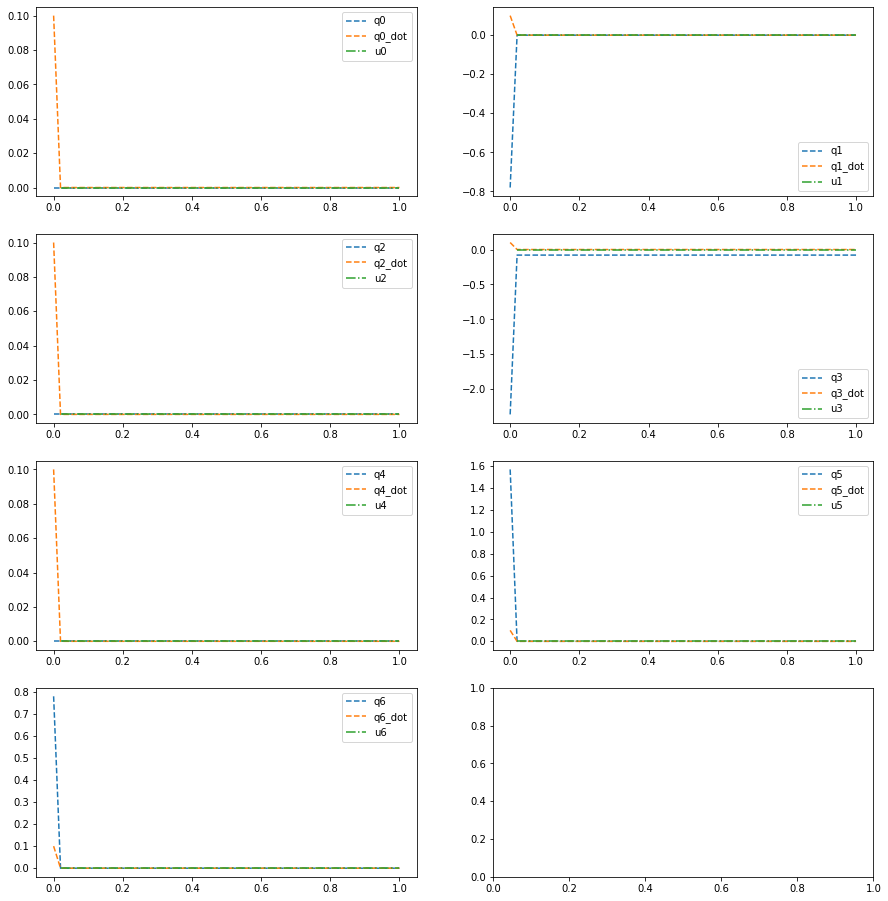

In [3]:
if __name__ == '__main__':
    if False:
        urdf_path = "urdf/rrbot.urdf"
        root = "link1" 
        end = "link3"
        def trajectory_target(t):
            q = [0]*2
            return q
        in_cond = [1]*4
    else:
        urdf_path = "../urdf/panda2.urdf"
        root = "panda_link0" 
        end = "panda_link8"
        def trajectory_target(t):
            q = [0]*7
            return q
        in_cond = [0,-0.78,0,-2.36,0,1.57,0.78] + [0.1]*7

    def my_cost_func(q, qd, u):
        return cs.mtimes(q.T,q)

    def my_final_term_cost(q_f, qd_f, u_f):
        return 10*cs.mtimes(q_f.T,q_f)  #+ cs.mtimes(qd_f.T,qd_f)
    

    time_horizon = 1
    steps = 50

    urdf_2_opt = Urdf2Moon(urdf_path, root, end)
    opt = urdf_2_opt.solve(my_cost_func, time_horizon, steps, in_cond, trajectory_target, my_final_term_cost, max_iter=70)
    fig = urdf_2_opt.print_results()